## Aim of this Practical


### In lectures and practicals so far, you've learnt about the role of open data, open-source tools, and network analysis using geospatial data. The aim of this practical is to integrate these aspects, using open-source Python tools to analyse network data, obtained from Openstreetmap, using a set of geospatial libraries. Whilst you're working through the practical, you should think about the issues we have discussed in the module up to now; namely the quality and suitability of OSM data for these kinds of applications, the strength of non-GIS platforms for analysis, and how interoperability allows us to do analysis wherever we want to do it, not just in desktop GIS.



# Network analysis with Python
This practical will explore how you can use Python to undertake network analysis. It will use a range of Python libraries, including APIs, or wrappers for APIs, to access and download data for our analysis.

## Set up our python environment
We need to install some libraries as those that need to be used aren't part of the standard Google Colab environment. Once installed, we can then import them as usual.

In [ ]:
# These should only be required on the first run :)
!pip install geopandas
!pip install osmnx
!pip install momepy
!pip install folium matplotlib mapclassify


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.5 MB/s eta 0:00:00


In [ ]:
# libary imports
import geopandas as gpd
import osmnx as ox
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import random
import pandas as pd

Note the large number of libraries we are importating. As we do more advanced analysis no one library is now sufficient. We need to use more libraries to access the different functionality they have so perform more complicated processing and analysis. This is one of the main reasons for using Python - it's easy to extend the functionality to meet our needs. In the same way that the open-source community contributes time and code to develop software like QGIS, the community has developed and shared a large number of free Python libraries to carry out a whole range of common and more complex geospatial operations.

# Define our location of interest
We will start by defining our location of interest, and use some of the libraries we've installed/imported to get some data and plot a map. Here we're defining our area of interest using a place name, that we'll then pass to a geocoder to translate that name into a polygon boundary. You could try experimenting by changing Newcastle to another place of your choosing and see what happens, but it might be safer to run through the practical with Newcastle first.

In [ ]:
# the chosen location for the analysis
place = "Newcastle upon Tyne, United Kingdom"

In [ ]:
# get the city boundary
boundary = ox.geocode_to_gdf(place)

Let's explain what that last cell/bit of code actually did. The code uses a library we've import as 'ox' (1), then a function in that library called 'geocode_to_gdf' (2) which was passed the text for our place (within the brakets). The output of this is then stored in a variable called boundary.

So, some detail:  
Part 1) ox is the short term for the library OSMNx which we imported at the beginning of this workbook. OSMNx is a library for accessing Open Street Map (OSM) data, and essesntially is a wrapper for the OSM API, so makes using the API much easier for us. The library actually was developed for doing network analysis using OSM data, designed to work with the python NetworkX library (hence the Nx at the end of the OSMNx library name), but we'll come to that later.
OSMNx docs: https://osmnx.readthedocs.io/en/stable/  
Part 2) The geocode_to_gdf function uses the OSM API to find a vector feature which matches the string of text which is passed to it. In this case we pass a place name, so we hope it returns, as a geodataframe (hence the 'to_gdf' in the function name), the administrative boundary for Newcastle Upon Tyne.

As said above, we have to hope that the OSM API has returned us the layer we are after. So we visualise it first before using it for some analysis. Running the line of code below will display the obtained polygon on a Leaflet map that we can zoom and pan around like a normal GIS display.

In [ ]:
# plot city boundary

# we can use .explore to plot a map similar to how we would in a "normal" GIS
boundary.explore()

## Creating a network

We will create a network using the data obtained through OSMNx now. To do this we'll use the graph_from_place method which allows us to pass a place name. We will also add a buffer of 100 metres so roads which might lie 100 meters outside the area area also downloaded.

In [ ]:
# get street network graph
g = ox.graph_from_place(place, network_type='all', buffer_dist = 100 )

<ipython-input-6-80c2540498f9>:2: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your query area directly, if desired.
  g = ox.graph_from_place(place, network_type='all', buffer_dist = 100 )
/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:360: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your results directly, if desired.
  gdf_place = geocoder.geocode_to_gdf(


As we are already familiar with geodataframes for handling, plotting and analysing spatial data, we wil convert the network data to a geodataframe. Note, we are only passing the edges of the network to the dataframe, not the nodes (refer to the lecture for the role these play in the network data structure).

In [ ]:
# convert to a geodataframe and plot
gdf = ox.graph_to_gdfs(g, nodes=False, edges=True)
gdf.explore()

# Analysis with networks

## Neighbourhood analsyis

We can use networks, such as the one we've just extracted representing roads, to help us understand not just how the road network functions or is structured, but also for other purposes. One such case is in identifying neighbourhoods: blocks of land which we identify as being a community, or an individual area. This might be useful if we are trying to define new 'Low Traffic Neighbourhoods' for intance, areas where through traffic is restricted to make the environment more pleasant for those that live there.
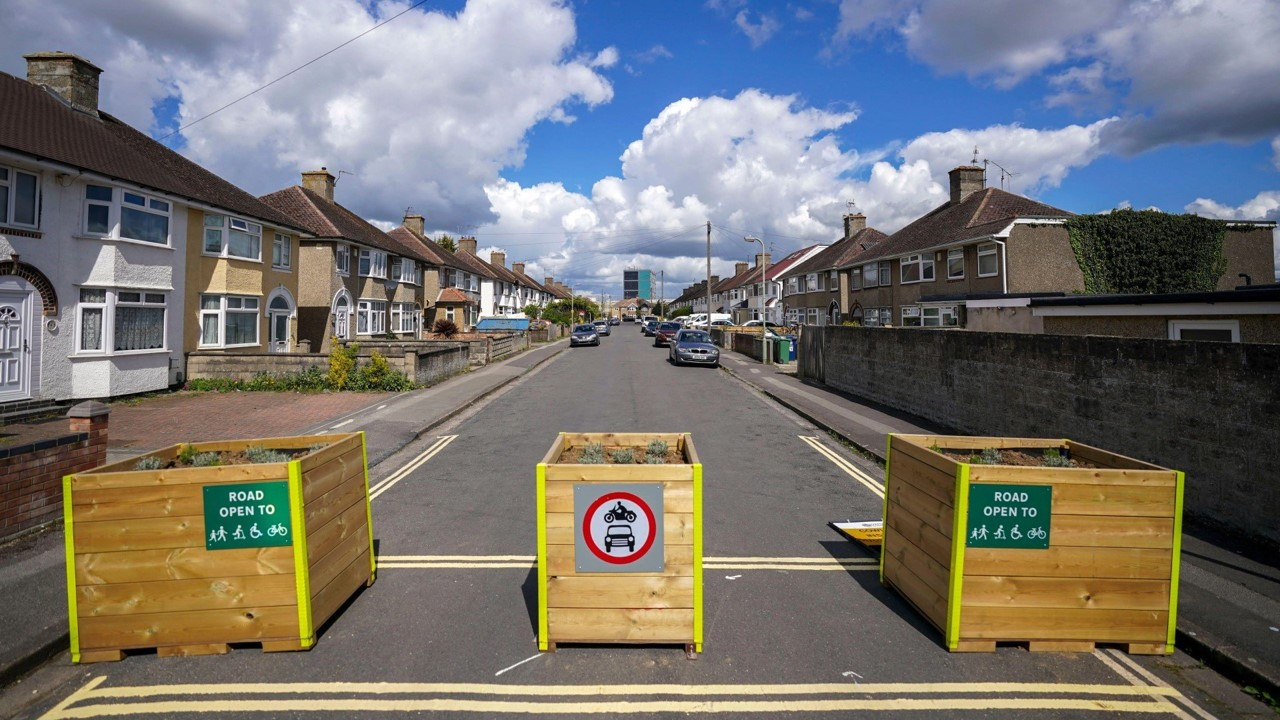

### Select defining roads

The first step is to identify those parts of the road network which we can use to define neighbourhoods. We can think about what forms the 'boundary' of a neighbourhood, but often this is major roads. Identifying such roads isn't always easy, as you will see below, due to the informal nature of Open Street Map data. Individuals can record data freely and thus the 'tags' or attributes they assign can vary, making selecting the important roads complex.

Here we'll use a rather complex query to select roads that are motorways, trunk roads, or classified roads with higher speed limits.

In [ ]:
# Find "boundary" roads
boundary_roads = gdf.loc[((gdf['highway'] == 'trunk') |
                        (gdf['highway'] == 'trunk_link') |
                        (gdf['highway'] == 'motorway') |
                        (gdf['highway'] == 'motorway_link') |
                        (gdf['highway'] == 'primary') |
                        (gdf['highway'] == 'primary_link') |
                        (gdf['highway'] == 'secondary') |
                        (gdf['highway'] == 'secondary_link') |
                        (gdf['highway'] == 'tertiary') |
                        (gdf['highway'] == 'tertiary_link') |
                        # speeds
                        (gdf['maxspeed'] == '60 mph') |
                        (gdf['maxspeed'] == '70 mph') |
                        (gdf['maxspeed'] == '40 mph') |
                        (gdf['maxspeed'] == ('20 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('40 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('60 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('50 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('20 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '70 mph'))
                        )]

In [ ]:
# plot boundary roads
boundary_roads.explore()

This cell output is too large and can only be displayed while logged in.


### Defining neighbourhoods

Now we have the major roads in our study area, we need to create some polygons for the neighbourhoods. To do this we use a polygon the covers the whole area then use spatial methods to disect it into the neighbourhoods. We can do this by buffering our roads to create a template which we can then 'cut out' of our study region boundary.

First, we'll create some functions to do some of the spatial operations.

In [ ]:
## buffering and dissolving functions

def buffer_and_dissolve(input_gdf):
    # Buffer around boundaries
    buffered_gdf = input_gdf.copy()  # Create a copy to avoid modifying the original
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(5) # set a 5 meter buffer

    # Dissolve the geometries
    dissolved_geo = buffered_gdf.unary_union

    # Create a new GeoDataFrame with the dissolved geometry
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])

    # Set the CRS (Coordinate Reference System)
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf

def dissolve_gdf(input_gdf):
    # dissolve geometries
    dissolved_geo = input_gdf.unary_union
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf

You will know by now that making sure coordinate systems for data is right before we do any analysis. Here we will convert both our datasets to the same coordiante reference system (CRS) to ensure they are both in the same and minimize the chance of errors.

In [ ]:
# to ensure only a 5 meter buffer is created, we need to change to a coordinate system that uses meters rather than degrees

boundary = boundary.to_crs(3857)
boundary_roads = boundary_roads.to_crs(3857)

Now let's run the data through those functions we defined a couple of steps ago.

In [ ]:
# buffer and dissolve

boundary_roads_bd = buffer_and_dissolve(boundary_roads)
boundary_features = dissolve_gdf(boundary_roads_bd)

There is still more spatial operations we need to need to run to create our distinct set of polygons for neighbourhoods. This involves using the 'erase' function to chop out our road network from the study area boundary, leaving a set of zones behind. We will run these now to generate the polygons.

In [ ]:
# Use the `difference` method to perform the "Erase" operation. This will produce a GeoSeries, so we will have to convert back to a Geodataframe
erased_boundary = boundary.difference(boundary_roads_bd.unary_union)

# Convert the GeoSeries to a single geometry using unary_union
erased_boundary = erased_boundary.unary_union

# Create a new GeoDataFrame with the result of "Erase" operation
erased_boundary_gdf = gpd.GeoDataFrame(geometry=[erased_boundary], crs=boundary.crs)

# explode multipolygon to polygons
erased_boundary_gdf = erased_boundary_gdf.explode()

# rename to neighbourhoods
neighbourhoods = erased_boundary_gdf

<ipython-input-13-a54e62ceb6ae>:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  erased_boundary_gdf = erased_boundary_gdf.explode()


Let's look at what all that processing has achieved.

In [ ]:
# now we have our neighbourhood zones for Newcastle
neighbourhoods.explore()

This cell output is too large and can only be displayed while logged in.


### Cleaning the data

Zoom in to Jesmond Metro Station. We can see that there are many small shapes still present in our neighbourhood dataset. This is a result of our processing and if we keep these in, we will end up with hundreds or even thousands of so-called neighbourhoods, and in some cases no buildings might even exist in these. We can remove these by calculating the area of all the "neighbourhoods" and removing very small ones.

In [ ]:
## drop very small areas (such as the centre of roundabouts etc)

# calculate area
neighbourhoods["area"] = neighbourhoods.geometry.area

# Drop rows where area is less than 5000. This value is arbitary
neighbourhoods = neighbourhoods.loc[neighbourhoods["area"] >= 10000]

In [ ]:
# we can now see that our issue as been resolved
neighbourhoods.explore()

You can see from the map that we now have a set of neighbourhoods for Newcastle. Have a look at the map and explore weather you think these look about right and make sense.

* What might cause any of the issues you find?
* Is there any other data we could have used to better define these neighbourhoods? What else might we use to define the 'boundary' of our neighbourhoods? (Hint: have a look near Chillingham Road Metro station)


## Identify a study area

Now we have these neighbourhoods, lets think about how we can use them to conduct some spatial analysis with these. To make our life a bit easier, we will however first assign unique IDs to each neighbourhood.

In [ ]:
## Create unique IDs

# Simple number based ID
neighbourhoods['ID'] = range(1, len(neighbourhoods) + 1)
neighbourhoods.explore()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Use the map above to look at the Negihbourhoods. You will see as you move over the map a pop-up gives you the 'area' and an 'ID' for each zone. Pick an area and select an ID, copying it into the variable below. This might be where you live, for example, but bear in mind that some neighbourhoods are more interesting to analyse than others...

In [ ]:
# The ID of the neighbourhood to explore. 191 is our 'default' ID
# Please change this value to an area of interest (we can come
#    back and change it again later)
neighbourhood_id = 191

In [ ]:
# Now we can just pick an area to work with
study_area = neighbourhoods[neighbourhoods['ID'] == neighbourhood_id].copy()

In [ ]:
# Check it's the area we wanted by mapping it
study_area.explore()

Now we have a study area boundary, lets crack on with some analysis within the neighbourhood to look at its characteristics. We will do this by looking at the building stock (the buildings in the area) and the transport network in the area.

## Building analysis

Buidlings can give clues to the characteristics of an area, such the population, the age of the areas, and the environment for the residents. By working with individual buildings we can begin to use spatial methods, such as spatial statistics or modelling, to derive values and maps about an area. We could then couple the building data, and what we can learn about them, to other datasets to derive new insights.

To begin with, we'll just look at the buildings themeselves. You have already used NIMSOD-DB to access buildings through QGIS from OS MasterMap, but there are other sources we can use. In this instance, we will use OpenStreetMap.

### Fetch and tidy some buidlings

In [ ]:
# lets do some analysis on our area

# first, lets get the buildings
# we need the input to the ox.features_from_polygon() function to be a polygon, rather than a gdf
# we also need to make sure it is in the correct coordinate system
study_area = study_area.to_crs('EPSG:4326')
study_area_polygon = study_area.iloc[0]['geometry'] # we create a polygon from the study_area geometry

# now lets get the buildings
buildings = ox.features_from_polygon(study_area_polygon, tags={'building': True})
buildings = ox.projection.project_gdf(buildings)
buildings.explore()

### Spatial analysis

Now we have the buidlings or area study area, we can begin to do some analysis.

First we'll add a new Python library to assess urban characteristics.

In [ ]:
# add this new library - https://docs.momepy.org/en/stable/
import momepy

We are first going to look at how big the houses, and the land they sit in, might be. This could be an indicator for the wealth of an area: the bigger the land area of each house, the more wealthy the residents of the area might be (although bear in mind some buildings might be communal like blocks of flat, and terraced streets are sometimes recorded in OpenStreetMap as a single large building!). Access to green space is also associated with health and wellbeing, so knowing how big gardens are can help with understanding this in a neighbourhood.

Unfortunately we need to do some spatail analysis to find out how big gardens might be as this data isn't easily accessable from Open Street Map. To do this we perform a 'Voronoi tessellation'. Look this up if you don't remember what it is.

In [ ]:


# we need to give buildings a buffer and a unqiue id in order to create a tessellation
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)

# now lets create the tessellation
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

Inward offset...
Generating input point array...
Generating Voronoi diagram...


/usr/local/lib/python3.10/dist-packages/momepy/elements.py:275: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  objects.loc[mask, objects.geometry.name] = objects[mask].buffer(


Generating GeoDataFrame...
Dissolving Voronoi polygons...


/usr/local/lib/python3.10/dist-packages/geopandas/tools/clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


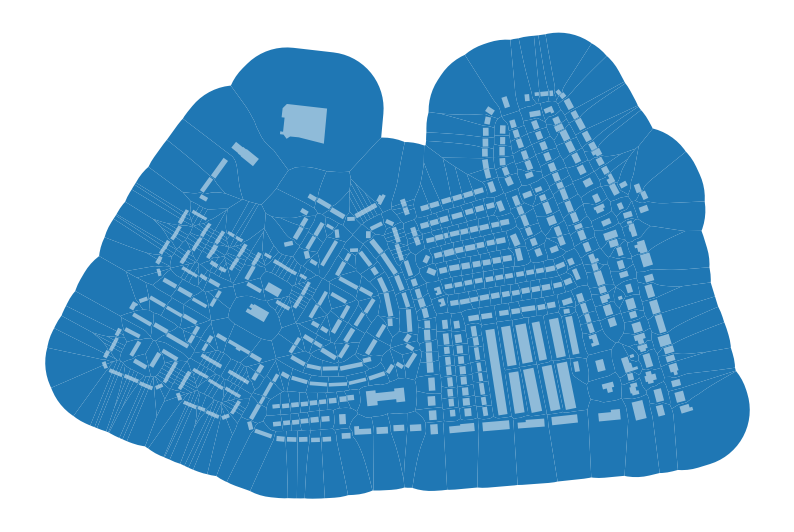

In [ ]:
# lets plot the building tesssellation

f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

This is nice to see and gives us an idea of the amount of space between buildings and potenitally the amount of garden space each set of buildings has. However, assessing this visually over a large area can be difficult, so let's try and produce some statistics to quantitatively show and compare buildings across our neighbourhood.

To do this we will compute the ratio between the area of the buidlings, and the area of the Voronoi polygon they sit in.

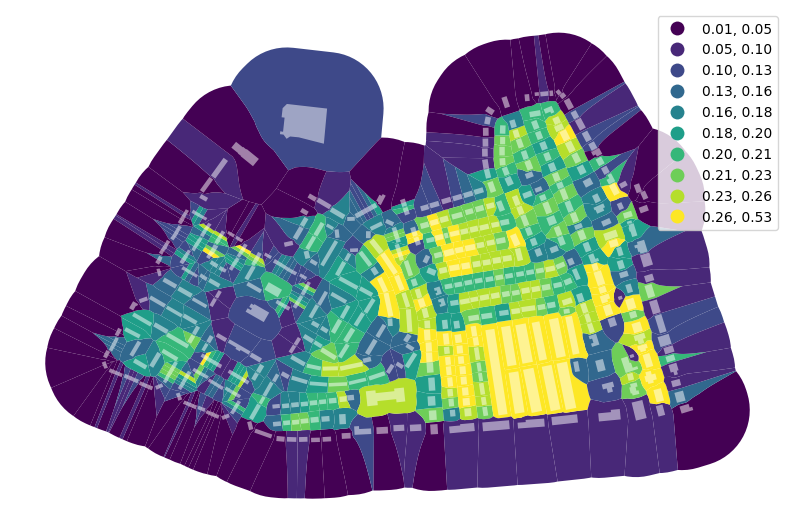

In [ ]:
# lets calculate the covered area ratio between the building and their area
# we can do this to think about how dense different parts of our neighbourhood area

tess_car = momepy.AreaRatio(tessellation, buildings,
                            momepy.Area(tessellation).series,
                            momepy.Area(buildings).series, 'uID')
tessellation['CAR'] = tess_car.series

f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='CAR', legend=True, scheme='quantiles', k=10, cmap='viridis')
buildings.plot(ax=ax, color='white', alpha=0.5)
ax.set_axis_off()
plt.show()

You can hopefully see from your map that there is variation across the nighbourhood. There is a bit of an issue at the edges of our study area as we don't have buildings there and the areas are therefore very large (we call these things "boundary effects). Across the rest of the data you may be able to extract some useful insights.


*   Are there distinct areas in the neighbourhood based on your assessment of the differences in the ratio?
*   What might these distinct areas suggest with regard to the sort, age or type of buidlings?



It may also be interesting to look at a range of the neighbourhoods across Newcastle to gain more insights into the typical building stock and building density across the city. However, for now, let's do some more analysis (if there is time at the end come back and repeat the analysis for different neighbourhoods).

In [ ]:
# we can also think about how diverse the buildings are within our area

# create spatial wieghts
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

# create tessellations
tessellation['area'] = momepy.Area(tessellation).series

  0%|          | 0/592 [00:00<?, ?it/s]

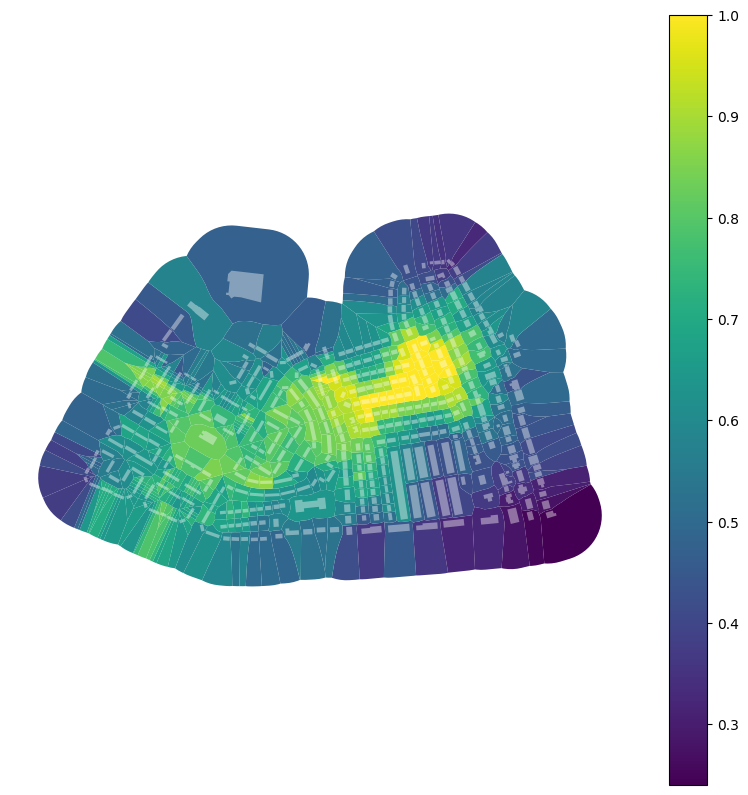

In [ ]:
# we can use the Simpson method to explore the diveristy

area_simpson = momepy.Simpson(tessellation, values='area',
                              spatial_weights=sw3,
                              unique_id='uID')
tessellation['area_simpson'] = area_simpson.series

# plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_simpson', legend=True, cmap='viridis')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

This index tells us how similar or different our areas are to each other. A value closer to 1 means that our buildings in this area are more similar to each other.

  0%|          | 0/592 [00:00<?, ?it/s]

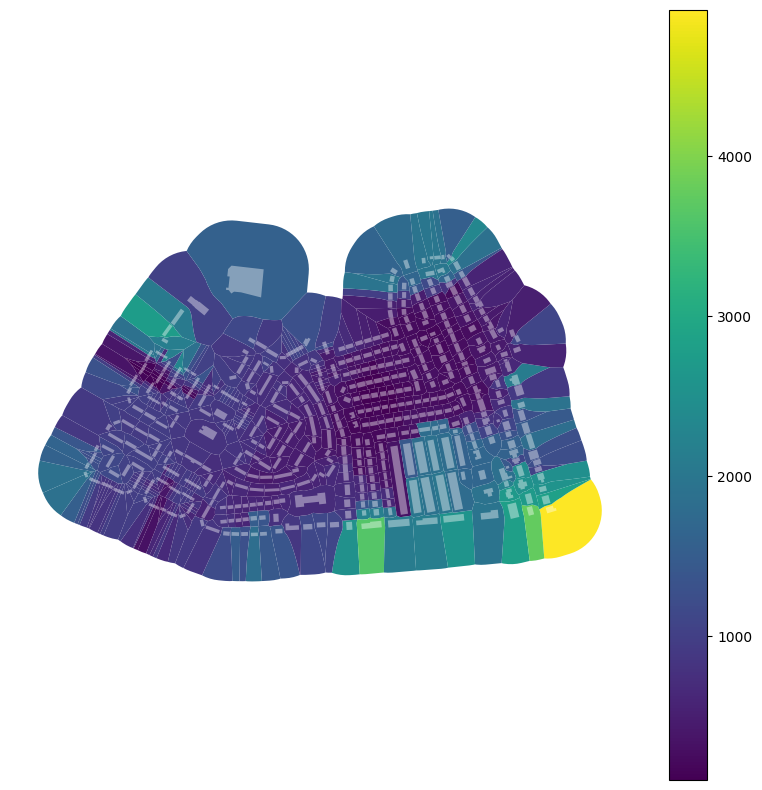

In [ ]:
# we can also use the range method. this measures the range of values within all neighbours as captured by the spatial weights

area_iqr = momepy.Range(tessellation, values='area',
                        spatial_weights=sw3, unique_id='uID',
                        rng=(25, 75))
tessellation['area_IQR'] = area_iqr.series

f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_IQR', legend=True, cmap='viridis')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

The smaller the range of values here, the less difference there is in the properties of our buildings. So darker purple areas are places where the 'building stock' is very alike. Which areas are these? Do they make sense?

## Network analysis

That demonstrates the kind of analysis we might be able to do using OpenStreetMap data and free Python libraries. Quite impressive, yes?!

With the road network data we extracted there are a whole host of other things we can look at and analyse using spatial metrics and Python libraries. One obvious thing we can do is explore the network itself, which we can do using a range of different methods.

Earlier we fetched the road network for Newcastle - this is a large network so it could a littile while to run some of the analysis. Therefore, as we already have a smaller study area which we used for the building analysis, let's continue to work within that area.

### Fetch the Network data

First we need to fetch the road network for your study area. Rather than using a place name though we need to use a polygon as our neighbourhoods aren't officially recognised places. We should still have our study area polygon defined from our earlier analysis.

In [ ]:
# lets do some network analysis on our streets

# we may want to include the roads which act as boundaries to our neighbourhood within our study area.
# we can access these roads by creating a small buffer around our area

# set the coordinate system to one which uses meters as the measurement unit
study_area = study_area.to_crs(3857)

# buffer and create polylgon for osmnx
study_area_buffer = study_area.buffer(15)
study_area_buffer = study_area_buffer.to_crs('EPSG:4326')
study_area_buffer_polygon = study_area_buffer.iloc[0] # we create a polygon from the study_area geometry

This time, rather than fetching the entire network, we will create three different networks for different transport options - one for walking, one for cycling, and one for driving.

In [ ]:
# get the walking and road networks
roads = ox.graph_from_polygon(study_area_buffer_polygon, network_type = 'drive', simplify=True)
walk = ox.graph_from_polygon(study_area_buffer_polygon, network_type = 'walk', simplify=True)
cycling = ox.graph_from_polygon(study_area_polygon, network_type = 'bike', simplify=True)

## **Task*
So we now have three networks.


*   Can you see the differences between the three networks? Look back to see how to visualise a network so you can compare the three options visually for your study area. See if you can enter the code in the empty block directly above this text.



### Identify importance of network elements

As covered in the lecture, there is a number of ways we can begin to characterise a network and its components (nodes and edges). Graph theory is a commonly used method and there are a large range of metrics we can use. One of the common ones is the betweenness (or betweenness centrality). If you can't remember what this is, take a look back at the lecture slides.

In [ ]:
# we can find where the most "important" street is within an area by calculating the betweenness centrailty of the network
# we need the networkx package for this (imported earlier as nx)


# calculate for road
roads_bc = nx.betweenness_centrality(ox.get_digraph(roads), weight="length")

# we can find the point in the network which has the most points going through it.
road_max_node, road_max_bc = max(roads_bc.items(), key=lambda x: x[1])
road_max_node, road_max_bc

(289996165, 0.5296712109061749)

Above we run the betweenness centrality method for the road network, using the length of the roads as a weight for the shortest path calculations.

We then find the road with the highest betweeness centrality value and the ID of this node.

To take a look at the result we can make a quick plot of the network and the node with the highest value.

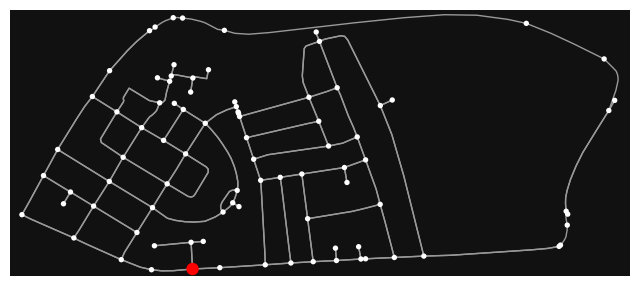

In [ ]:
# plot the most important node within the walking network

# for all nodes in the network, if the node is the node with the maximum value
# ... set it as 'r' (red) else set it as 'w' (white)
road_nc = ["r" if node == road_max_node else "w" for node in roads.nodes]

# for all nodes in the network, if the node is the node with the maximum value
# ... set it as '80' else set it as 15
road_ns = [80 if node == road_max_node else 15 for node in roads.nodes]

# plot the network using the two datasets created above, and the road network
fig, ax = ox.plot_graph(roads, node_size=road_ns, node_color=road_nc, node_zorder=2)

This plot hopefully shows with a red larger dot, where the node with the highest value is and thus potentially the most important node (road junction) in the network is.

## **Task*

You have looked at the road network already.


*   Repeat the analysis above done for the road network but for the walking network. Do you get a different result?
*   Have a go at the cycling network too. Does this differ again?




### Identify importance of network elements (continued)

The analysis above just looked at the nodes, but we can also look at the edges in the network too. To simplify this process, we create a function which does this for us and makes the process easily repeatable for any network we want to analyse.

In [ ]:
# we can inspect the most important edges within our network too
# we can calculate the edge based betweenness centrality to view this.

# this function will plot the edge-based betweenness centrality
def plot_betweenness_centrality(network, network_name):
    # Calculate the betweenness centrality for edges
    network_betweenness = momepy.betweenness_centrality(network, mode='edges', weight='length')
    edge_betweenness = nx.edge_betweenness_centrality(network_betweenness, weight="length")

    # Normalize the betweenness centrality values to be in the range [0, 1]
    max_bc = max(edge_betweenness.values())
    normalized_edge_betweenness = {edge: bc / max_bc for edge, bc in edge_betweenness.items()}

    # Extract the edges and corresponding betweenness centrality values
    edges, bc_values = zip(*normalized_edge_betweenness.items())

    # Convert the betweenness centrality values to a valid RGBA format for plotting
    cmap = plt.get_cmap('viridis')
    edge_colors = [cmap(bc) for bc in bc_values]

    # Create a GeoDataFrame with the edge geometries
    gdf_edges = ox.graph_to_gdfs(network_betweenness, nodes=False, fill_edge_geometry=True)

    # Plot the network with edge colors based on betweenness centrality
    fig, ax = ox.plot_graph(network_betweenness, node_color='k', bgcolor='w', node_zorder=2, edge_color=edge_colors, edge_linewidth=2, show=False)

    # Add a colorbar for the edge colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", shrink=0.5)
    cbar.set_label('Normalized Edge Betweenness Centrality')

    plt.title(f'{network_name} Betweenness Centrality')
    plt.show()

Now we have created the function, lets actually use it and start exploring our data.

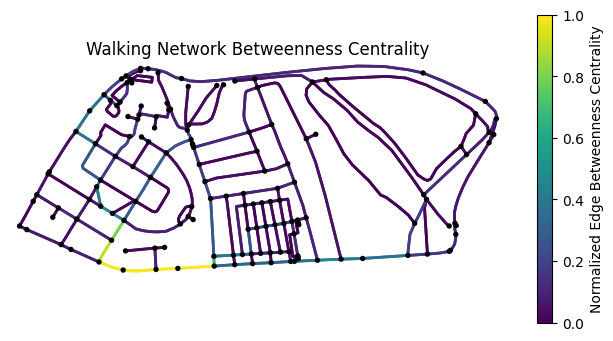

In [ ]:
# plot walking values
plot_betweenness_centrality(walk, 'Walking Network')

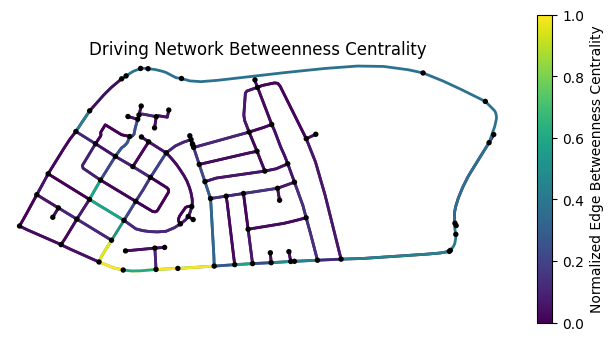

In [ ]:
# plot driving values
plot_betweenness_centrality(roads, 'Driving Network')

You can hopefully see the differences between the two networks here. The most important links in the walking network are not the same as the most important links in the driving network. What does this tell us about the differences in the networks?

## Modelling modal-filters

We can use the betweenness measures as indicators as to the most important local links within a neighbourhood and using this we can model the potential changes to traffic patterns when links are added or removed.

In recent years, the use of 'modal filters' has increased within urban areas as a means of making neighbourhoods more livable. Modal filters are a simple method of adding physical interventions to streets allowing pedestrain and cyclists to pass through an area whilst reducing the amount of motor vehicle traffic which can travel along the same link, thus making it safer for these other users and those that live in the area. This is commonly achived through the use of bollards, planters and kerbs which stop larger vehicles getting through.

In this next section, we can simulate adding modal filters to a network to see how the importance of streets change.


### Creating a modal-filter

We could pick any edge we like to simulate the introduction of a modal filter, and we might see an impact. However, in this case to make sure we see a change for the purpose of demonstrating the methods to do such analysis, we will pick the edge with the greatest betweenness value.

So first we'll calcualte the edge betweenness centrality for the three networks so we have a baseline set of values we can measure the impact against and identify the edge to remove.

In [ ]:
road_betweenness = nx.edge_betweenness_centrality(roads, weight="length", normalized=True)
walk_betweenness = nx.edge_betweenness_centrality(walk, weight="length", normalized=True)
cycle_betweenness = nx.edge_betweenness_centrality(cycling, weight="length", normalized=True)

Now we have the betweenness centrality values for all the edges, we can introduce a modal filter and look at the impact this might have. The code below essentailly assignes the betweeness values to the edges that we have already calculated, finds the edge with the maximum value, then rebuilds the network with teh full set of nodes and the reduced set of edges, creating a new version of the network.

In [ ]:
# Convert the road network to a GeoDataFrame
road_nodes, road_edges = ox.graph_to_gdfs(roads)

# drop all the "reverse" roads
# with our current model of the road network, we have both the "up" and "down" road
# this is to represent the bi-directional nature of most roads
# however we can just assume all roads within our area will be bi-directional for simplicity
road_edges = road_edges.loc[road_edges['reversed'] != True]

# create an "blank" column to be filled with our betweenness values
road_edges['betweenness'] = 0.0  # Initialize the column with zeros

# Iterate through the rows and set the betweenness values
for index, row in road_edges.iterrows():
    edge_id = (index[0], index[1], 0)  # Create the edge identifier as a tuple
    betweenness = road_betweenness.get(edge_id, 0.0)  # Use the edge_id to retrieve betweenness
    road_edges.at[index, 'betweenness'] = betweenness

# Find the index of the row with the largest betweenness value
max_betweenness_index = road_edges['betweenness'].idxmax()

# Drop the row with the largest betweenness value
road_edges = road_edges.drop(index=max_betweenness_index)

# now we can join the edges and nodes back together to become a network again
roads_reduced = ox.graph_from_gdfs(road_nodes, road_edges)


The above works, but as before, if we want to run this for each network, we should probably make it a function.



***

In [ ]:
# function to remove the edge with the highest centrailty value

def remove_highest_betweenness(gdf, betweenness_values):
    # Convert the road network to a GeoDataFrame
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(gdf)

    # Drop all the "reverse" roads
    # With our current model of the road network, we have both the "up" and "down" road
    # This is to represent the bi-directional nature of most roads, but we can assume
    # all roads within our area will be bi-directional for simplicity.
    gdf_edges = gdf_edges.loc[gdf_edges['reversed'] != True]

    # Create a "blank" column to be filled with our betweenness values
    gdf_edges['betweenness'] = 0.0  # Initialize the column with zeros

    # Iterate through the rows and set the betweenness values
    for index, row in gdf_edges.iterrows():
        edge_id = (index[0], index[1], 0)  # Create the edge identifier as a tuple
        betweenness = betweenness_values.get(edge_id, 0.0)  # Use the edge_id to retrieve betweenness
        gdf_edges.at[index, 'betweenness'] = betweenness

    # Find the index of the row with the largest betweenness value
    max_betweenness_index = gdf_edges['betweenness'].idxmax()

    # Drop the row with the largest betweenness value
    gdf_edges = gdf_edges.drop(index=max_betweenness_index)

    # Now we can join the edges and nodes back together to become a network again
    reduced_network = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

    return reduced_network

Using the function, we can now do the analysis very quickly using the different networks we have. Let's first start with the road network.

In [ ]:
# We can remove the most important link within our network to see how this would
#... impact the traffic within the neighbourhood. We'll use the function
#... defined above
roads_reduced = remove_highest_betweenness(roads,road_betweenness)

This 'reduced network', represents our network with a modal filter added (and thus the edge removed) on the road link with the highest betweenness centrality (i.e. the most shortest routes running through it). We can now re-run the betweenness centrality calculations to see where the routes now divert to. Even better, we can use one of the functions defined earlier to do this!

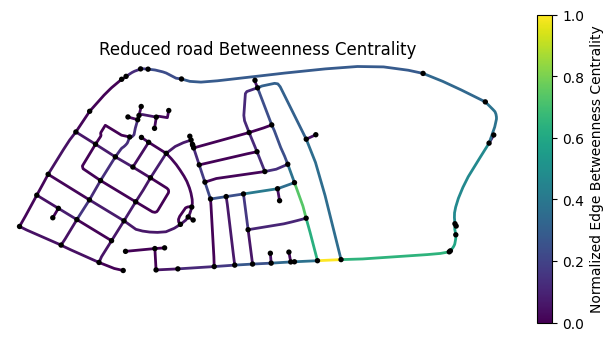

In [ ]:
plot_betweenness_centrality(roads_reduced, "Reduced road")

You can see from the map the more of the routes now follow our "boundary roads", which is exactly what a low-traffic neighbourhood is designed to do!

### Impact on journey distances

Running analysis using graph metrics like betweenness is useful and can give some nice insights into the structure of the network. It doesn't always capture the true nature of how people might use the network, however, and the sort of journeys that will be made. Using data of actual journeys would give us some better information on the impact, but unfortunately we often don't have that data. Therefore as an alternative we can just create some random journeys.

We'll create a set of ten journeys, picking the start and end nodes at random from our network.

In [ ]:
# now lets see how modelling a modal filter can change the distances of travel for different modes
# first we will select 10 random pairs of nodes to act as our inter-neighbourhood trips
num_pairs = 10 # number of journeys
random_node_pairs = []

for _ in range(num_pairs):
    source = random.choice(list(roads.nodes())) # set origin nodes
    target = random.choice(list(roads.nodes())) # set destination nodes
    while source == target:
        target = random.choice(list(roads.nodes()))  # Ensure origin and destination are different
    random_node_pairs.append((source, target))

We will set up our networks to be 'undirected' (meaning people can travel either way on every road). This might not be the case in reality but it simplifies our analysis.

In [ ]:
# we will set the network be undirected
# this will reduce the realism of the model, but make the data much easier to work with
# we will assume all streets can be traveled in a two way direction
roads = roads.to_undirected(as_view=True)

# we will also set our reduced roads network to undirected, as we will need it later
roads_reduced = roads_reduced.to_undirected(as_view=True)

Now we can calculate the shortest path between each of the node pairs along our network. To do this we'll loop through our pairs of nodes as created above, and for each use a shortest path algorithm to find the path between these.

In [ ]:


# create an empty list
shortest_routes = []

# for every pair of nodes, find the shortest path and add the route to our list
for origin, destination in random_node_pairs:
    if origin != destination:
        shortest_path = nx.shortest_path(roads, origin, destination, weight="length")
        shortest_routes.append(shortest_path)

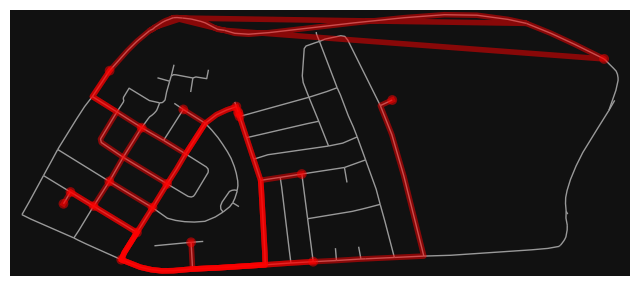

In [ ]:
# Plot the map with the routes
fig, ax = ox.plot_graph_routes(roads, shortest_routes, route_colors="r", route_linewidth=6, node_size=0, orig_dest_size=50)

The map should show the journeys from your 10 random pairs of nodes you generated. Depending on the size of your study area, 10 journeys might not be that useful, and perhaps using more might give some better insights.

## **Task*
Change the number of random journeys to those a value which you think works better for your study area. Can you see which of the roads in your neighbour are the most likely to carry higher numbers of journeys?

### Calculating journey distances

Being able to map the journeys is useful, but to measure the impact knowing how long each journey is would be really useful. This will also enable us to compare not just the impact of a modal filter, but compare the different travel methods too (driving, cycling, and walking).

Network x doesn't tell us the shortest path, it just gives us the path, so we need to loop through each path, and in turn loop through each edge in that path and find the length of the edge, adding these up as we go along.

In [ ]:
# we can find how far each of these trips are, and create a dataframe

# Calculate the distance of each shortest path
distances = [sum(roads[shortest_path[i]][shortest_path[i + 1]][0]["length"] for i in range(len(shortest_path) - 1)) for shortest_path in shortest_routes]

# Create a dataFrame
roads_distance = pd.DataFrame({
    "Origin": [pair[0] for pair in random_node_pairs],
    "Destination": [pair[1] for pair in random_node_pairs],
    "Distance (meters)": distances
})

# Add an incrementing index
roads_distance.index = range(1, len(roads_distance) + 1)

# Print the DataFrame
print(roads_distance)

        Origin  Destination  Distance (meters)
1    299769141    262862516           1553.175
2    299769155    266685251            717.561
3   9730345603   1164017256           1935.658
4    299769146    299769123            224.164
5    289996166    268484632            586.757
6    268484624    289996163            508.807
7    299769138   9560520343            863.780
8    299769140    299769160            146.283
9    299769096    299769151            325.989
10   268484626    828944152           1451.356


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


We now have a dataframe for our journeys which includes the length of each. We will use this later.

As we want to repeat the last few steps to find the distance of the shortest paths for different networks, and potentially different locations of modal filters, we once again can put the code into a easy to use function, saving us a lot of effort in the next few steps.

In [ ]:
# we can put the code we have previously used into a function to streamline the processing

def calculate_shortest_distances(graph, node_pairs):
    shortest_routes = []

    for origin, destination in node_pairs:
        if origin != destination:
            try:
                shortest_path = nx.shortest_path(graph, origin, destination, weight="length")
                shortest_routes.append((origin, destination))  # Append the pair as a tuple
            except nx.NetworkXNoPath:
                print(f"No path found between {origin} and {destination}")

    # Filter valid node pairs
    valid_node_pairs = shortest_routes

    distances = []
    for pair in valid_node_pairs:
        distance = 0  # Initialize distance to 0
        origin, destination = pair
        if origin != destination:
            shortest_path = nx.shortest_path(graph, origin, destination, weight="length")
            for i in range(len(shortest_path) - 1):
                distance += graph[shortest_path[i]][shortest_path[i + 1]][0]["length"]
            distances.append(distance)

    df = pd.DataFrame({
        "Origin": [pair[0] for pair in valid_node_pairs],
        "Destination": [pair[1] for pair in valid_node_pairs],
        "Distance (meters)": distances
    })

    df.index = range(1, len(df) + 1)

    return df

# we then get the distance calculation returned as a dataframe
roads_reduced_distance = calculate_shortest_distances(roads_reduced, random_node_pairs)


Now that is done, we can move forward with undertaking our analysis. First we'll calcualte the differences between the original network and the reduced network (with the modal filter).

In [ ]:
# we can now compare the distances from both dataframes to measure the impact of removing the link
# even removing just one short link in a neighbourhood can have large differance!

# we can pull some basic stats
# Calculate the differences
differences = roads_distance['Distance (meters)'] - roads_reduced_distance['Distance (meters)']
differences_df = pd.DataFrame({'Differences (meters)': differences})
# Convert differences to absolute values
differences_df['Differences (meters)'] = differences_df['Differences (meters)'].abs()

# Print the differences dataframe
print(differences_df)

# calculate max and total
total_difference = differences_df['Differences (meters)'].sum()
max_difference = differences_df['Differences (meters)'].max()

# Print
print("Total Difference (meters):", total_difference)
print("Max Difference (meters):", max_difference)

    Differences (meters)
1               1589.490
2               2295.458
3                  0.000
4                  0.000
5                  0.000
6                  0.000
7               2795.783
8                  0.000
9                  0.000
10              1603.849
Total Difference (meters): 8284.580000000002
Max Difference (meters): 2795.7830000000004


Hopefully you can see some differences.



*   What does this show? Are there any differences in your journeys?
*    Has the modal filter had an impact? If so, how?



### Comparing non-driving to driving

You have analysed the impact on driving, but low traffic neighbourhoods are about reducing traffic in these neighbourhoods, with the benefit of being safer and more attractive for walking and cycling. To measure the true impact, therefore, we need to compare the distances for walking and cycling, to those for driving with the modal filter in place.

Like for driving, we need to create a set of random journeys. As the networks may have different nodes in them, we need to create these carefully to ensure the journeys can be completed by all three methods of travel.

In [ ]:
# we can also compare the distances between nodes using the cycling and walking networks to get a sense of how "liveable"
# a "living" neighbourhood generally has a greater accessiablity by walking and cycling than cars, making the streets quieter and more people friendly

# lets compare the the normal driving network to the walking and cycling networks

# we need to choose 10 different pairs of nodes to ensure that the nodes are found across all networks

# Create a list to store the random node pairs
common_node_pairs = []

# Generate random pairs of nodes that are common to all three graphs
while len(common_node_pairs) < num_pairs:
    # Choose random source and target nodes
    source = random.choice(list(walk.nodes()))
    target = random.choice(list(walk.nodes()))

    # Ensure that the source and target are different
    while source == target:
        target = random.choice(list(walk.nodes()))

    # Check if the selected nodes are also in the other graphs
    if (
        source in cycling.nodes()
        and target in cycling.nodes()
        and source in roads.nodes()
        and target in roads.nodes()
    ):
        pair = (source, target)
        # Check if the pair is not already in the common_node_pairs list
        if pair not in common_node_pairs:
            common_node_pairs.append(pair)

Great, now we can run the analysis again for all three networks.

In [ ]:
# now lets find the the travel distances
walk_distance = calculate_shortest_distances(walk, common_node_pairs)
bike_distance = calculate_shortest_distances(cycling, common_node_pairs)
roads_distance = calculate_shortest_distances(roads, common_node_pairs)

Now we have the distances for our journeys, we need to plot these so we can compare them really easily.

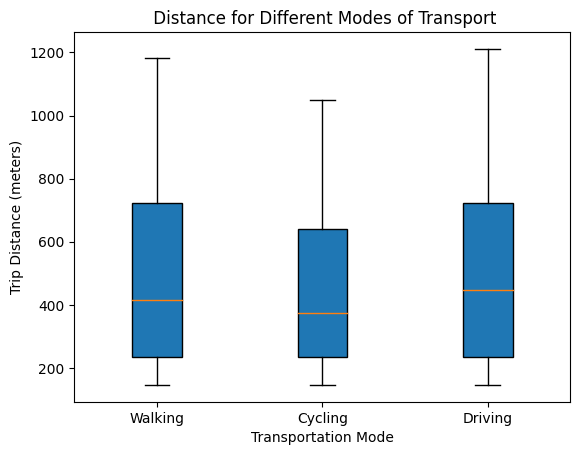

In [ ]:
# now lets plot the distances. If all plots look the same, this is due to the networks having the same accessiablity, indicating low liveablity
# try changing the study area to see if this impacts the liveablity

import matplotlib.pyplot as plt

# Assuming you have the data in lists as follows
# avg_distances is a list of lists, one for each transportation mode
avg_distances = [
    walk_distance["Distance (meters)"],
    bike_distance["Distance (meters)"],
    roads_distance["Distance (meters)"]
]

labels = ['Walking', 'Cycling', 'Driving']

# Create a box plot
plt.boxplot(avg_distances, labels=labels, patch_artist=True)


# Set the title and labels
plt.title(" Distance for Different Modes of Transport")
plt.xlabel("Transportation Mode")
plt.ylabel("Trip Distance (meters)")

# Show the plot
plt.show()


## **Task*

Hopefully the chart shows you some variations between the three methods of travel.


*   What does the chart show? Are there significant differences?
*   The chart only includes the distance for the road network, what happens if the distances for the reduced road network are used?
* How do your results compare to that found by others in the class with different study areas? Are the differences between cycling and driving bigger or smaller?




That is the end of this practical. Hopefully you have seen how we can use free open-source Python geospatial libraries with volunteered geographic information like OpenStreetMap to carry out some quite sophisticated analysis of transport networks. This is just one example of how this combination of open data and open-source tools can help address sustainability challenges like those in transport, and make progress towards decarbonisation and the UN Sustainable Development Goals.

**END OF PRACTICAL**